# Replicating TCAV Study

> This notebook aims to replicate the study ["Interpretability Beyond Feature Attribution: Quantitative Testing with Concept Activation Vectors (TCAV)"](https://arxiv.org/pdf/1711.11279.pdf). 

> We have created a more transparent folder structure, to make it easier for others to replicate the study.  The file "Run_TCAV.ipynb" is the original file modified to the new folder structure, here more specifications about the TCAV packages can be found. If you are interested in obtaining the original file it can be done here --> [TCAV repository](https://github.com/tensorflow/tcav). 


> Table of contents:
1. Preparation for using the TCAV packages

    1.1 TCAV step-by-step

2. The Zebra Example

3. The Zebra Test Example

4. The School Bus Example 

5. The School Bus Test Example 

--------------------------------------------------

## 1. Preparation for using the TCAV packages

> Required Packages:

In [1]:
# %pip install tensorflow
# %pip install tcav

%load_ext autoreload
%autoreload 2

import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

import json

> Set the right folders and path's: 

In [2]:
print ('REMEMBER TO UPDATE YOUR_PATH (where images, models are)!')

# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'  
user = 'andre' #updated
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test4'
working_dir = "/tmp/" + user + '/' + project_name
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ '/activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + '/cavs/'
# where the images live.

# TODO: replace 'YOUR_PATH' with path to downloaded models and images. 
# source_dir = "C:/Users/andre/OneDrive/Skrivebord/TCAV_Deep_Learning"
source_dir = "C:/Users/julie/Documents/GitHub/TCAV_Deep_Learning"

utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   


REMEMBER TO UPDATE YOUR_PATH (where images, models are)!


In [3]:
import os
os.getcwd()
os.chdir(source_dir)

### 1.1 TCAV step-by-step

> The following is taken from the original file

1. **Store example images in each folder**
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **Write a model wrapper** (below uses example from tcav/model.py)
 * an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **Retrieve model activations** (below uses example from tcav/activation_generator.py)
 * an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model
4. Run TCAV and visualize scores for important concepts.

-----------

## 2. The Zebra Example 

> Step 1: Store concept and target class images to local folders

In [4]:
# list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.
bottlenecks = [ 'mixed3a','mixed3b','mixed4a', 'mixed4b', 'mixed4c','mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']
# Possible layer names: 
# layer_names = ['conv2d0', 'conv2d1', 'conv2d2',
#                 'mixed3a', 'mixed3b',
#                 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
#                 'mixed5a', 'mixed5b']

# names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir
target = 'zebra'  
concepts = ["dotted","striped","zigzagged"]  


> Step 2: Write to the pretrained model wrapper

In [5]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = source_dir + "/pretrained_model/inception5h/tensorflow_inception_graph.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. 
LABEL_PATH = source_dir + "/pretrained_model/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

> Step 3: Implement a class that returns activations 

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations.


In [6]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir+'/concepts', activation_dir, max_examples=100)

> Step 4: Run TCAV and visualize concept importance

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 


In [7]:
import absl
absl.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:mixed3a ['dotted', 'random500_0'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_2'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_3'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_4'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_5'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_6'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_7'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_8'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_9'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_0'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_2'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_3'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_4'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_5'] zebra 0.1
INFO:tensorflow:mixed3a ['striped'

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 64 of 1080
INFO:tensorflow:running zebra ['random500_3', 'random500_8']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_3_mixed3a shape (73, 28, 28, 256)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_8_mixed3a shape (74, 28, 28, 256)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_zebra_mixed3a shape (73, 28, 28, 256)
INFO:tensorflow:Training CAV ['random500_3', 'random500_8'] - mixed3a alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.36, 'random500_8': 0.4583333333333333, 'overall': 0.40816326530612246}
INFO:tensorflow:CAV accuracies: {'random500_3': 0.36, 'random500_8': 0.4583333333333333, 'overall': 0.40816326530612246}
INFO:tensorflow:Running param 65 of 1080
INFO:tensorflow:running zebra ['random500_3', 'random500_9']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_3_mixed3a shape (73, 28, 28,

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 398 of 1080
INFO:tensorflow:running zebra ['random500_0', 'random500_9']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_0_mixed4b shape (87, 14, 14, 512)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_9_mixed4b shape (83, 14, 14, 512)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_zebra_mixed4b shape (73, 14, 14, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_9'] - mixed4b alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.5714285714285714, 'random500_9': 0.5555555555555556, 'overall': 0.5636363636363636}
INFO:tensorflow:CAV accuracies: {'random500_0': 0.5714285714285714, 'random500_9': 0.5555555555555556, 'overall': 0.5636363636363636}
INFO:tensorflow:Running param 399 of 1080
INFO:tensorflow:running zebra ['random500_1', 'random500_0']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 430 of 1080
INFO:tensorflow:running zebra ['random500_4', 'random500_5']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_4_mixed4b shape (87, 14, 14, 512)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_5_mixed4b shape (75, 14, 14, 512)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_zebra_mixed4b shape (73, 14, 14, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_5'] - mixed4b alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.52, 'random500_5': 0.48, 'overall': 0.5}
INFO:tensorflow:CAV accuracies: {'random500_4': 0.52, 'random500_5': 0.48, 'overall': 0.5}
INFO:tensorflow:Running param 431 of 1080
INFO:tensorflow:running zebra ['random500_4', 'random500_6']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_4_mixed4b shape (87, 14, 14, 512)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/a

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 682 of 1080
INFO:tensorflow:running zebra ['random500_5', 'random500_8']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_5_mixed4d shape (75, 14, 14, 528)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_8_mixed4d shape (74, 14, 14, 528)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_zebra_mixed4d shape (73, 14, 14, 528)
INFO:tensorflow:Training CAV ['random500_5', 'random500_8'] - mixed4d alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.875, 'random500_8': 0.12, 'overall': 0.4897959183673469}
INFO:tensorflow:CAV accuracies: {'random500_5': 0.875, 'random500_8': 0.12, 'overall': 0.4897959183673469}
INFO:tensorflow:Running param 683 of 1080
INFO:tensorflow:running zebra ['random500_5', 'random500_9']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_5_mixed4d shape (75, 14, 14, 528)
INFO:tensorflow:Load

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 797 of 1080
INFO:tensorflow:running zebra ['random500_5', 'random500_2']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_5_mixed4e shape (75, 14, 14, 832)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_2_mixed4e shape (87, 14, 14, 832)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_zebra_mixed4e shape (73, 14, 14, 832)
INFO:tensorflow:Training CAV ['random500_5', 'random500_2'] - mixed4e alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.68, 'random500_2': 0.4, 'overall': 0.54}
INFO:tensorflow:CAV accuracies: {'random500_5': 0.68, 'random500_2': 0.4, 'overall': 0.54}
INFO:tensorflow:Running param 798 of 1080
INFO:tensorflow:running zebra ['random500_5', 'random500_3']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_5_mixed4e shape (75, 14, 14, 832)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/a

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 896 of 1080
INFO:tensorflow:running zebra ['random500_2', 'random500_9']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_2_mixed5a shape (87, 7, 7, 832)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_9_mixed5a shape (83, 7, 7, 832)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_zebra_mixed5a shape (73, 7, 7, 832)
INFO:tensorflow:Training CAV ['random500_2', 'random500_9'] - mixed5a alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.3333333333333333, 'random500_9': 0.6428571428571429, 'overall': 0.4909090909090909}
INFO:tensorflow:CAV accuracies: {'random500_2': 0.3333333333333333, 'random500_9': 0.6428571428571429, 'overall': 0.4909090909090909}
INFO:tensorflow:Running param 897 of 1080
INFO:tensorflow:running zebra ['random500_3', 'random500_0']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test3/activations/acts_random500_3_mixe

> Export the result to a json file in the 'result folder':

In [8]:
import json
with open('.\\results\\Zebra_all_layers', 'w+') as json_file:
    json.dump(results, json_file)

> Plot the results:

In [9]:
# Import the results 
# os.listdir(os.getcwd()+"\\results")

f = open('.\\results\\Zebra_all_layers', 'r')
results_zebra= json.load(f)


In [12]:
# Example of how the datastructure is: 
results_zebra[0]

{'cav_key': 'dotted-random500_0-mixed3a-linear-0.1',
 'cav_concept': 'dotted',
 'negative_concept': 'random500_0',
 'target_class': 'zebra',
 'cav_accuracies': {'dotted': 0.9310344827586207,
  'random500_0': 0.9310344827586207,
  'overall': 0.9310344827586207},
 'i_up': 0.589041095890411,
 'val_directional_dirs_abs_mean': 0.009407010347435579,
 'val_directional_dirs_mean': 0.006357713856801805,
 'val_directional_dirs_std': 0.03845146951455528,
 'val_directional_dirs': [0.007311848917455091,
  0.04796798139346375,
  -0.0006663362725419755,
  -1.2071938090167819e-05,
  -9.56962070055647e-05,
  1.60237484629728e-05,
  -5.921605315426323e-08,
  6.400925715536383e-05,
  2.483188106516299e-06,
  -1.0553449554216749e-07,
  -0.00012721740648712778,
  1.2333259761228404e-06,
  -1.7583876346487656e-06,
  0.02113064881399619,
  2.1485681532970672e-07,
  -0.00021912966210732376,
  1.3775340399838451e-06,
  1.3365851989566332e-05,
  -0.0001060819599719388,
  1.298101394164076e-07,
  -0.000409641208

Class = zebra
  Concept = dotted
    Bottleneck = mixed3a. TCAV Score = 0.41 (+- 0.08), random was 0.50 (+- 0.09). p-val = 0.006 (significant)
    Bottleneck = mixed3b. TCAV Score = 0.39 (+- 0.10), random was 0.49 (+- 0.10). p-val = 0.002 (significant)
    Bottleneck = mixed4a. TCAV Score = 0.28 (+- 0.07), random was 0.50 (+- 0.14). p-val = 0.000 (significant)
    Bottleneck = mixed4b. TCAV Score = 0.15 (+- 0.07), random was 0.51 (+- 0.16). p-val = 0.000 (significant)
    Bottleneck = mixed4c. TCAV Score = 0.47 (+- 0.15), random was 0.49 (+- 0.20). p-val = 0.792 (not significant)
    Bottleneck = mixed4d. TCAV Score = 0.64 (+- 0.17), random was 0.51 (+- 0.27). p-val = 0.143 (not significant)
    Bottleneck = mixed4e. TCAV Score = 0.65 (+- 0.34), random was 0.48 (+- 0.28). p-val = 0.067 (not significant)
    Bottleneck = mixed5a. TCAV Score = 0.85 (+- 0.10), random was 0.48 (+- 0.26). p-val = 0.000 (significant)
    Bottleneck = mixed5b. TCAV Score = 0.50 (+- 0.37), random was 0.50 (+- 

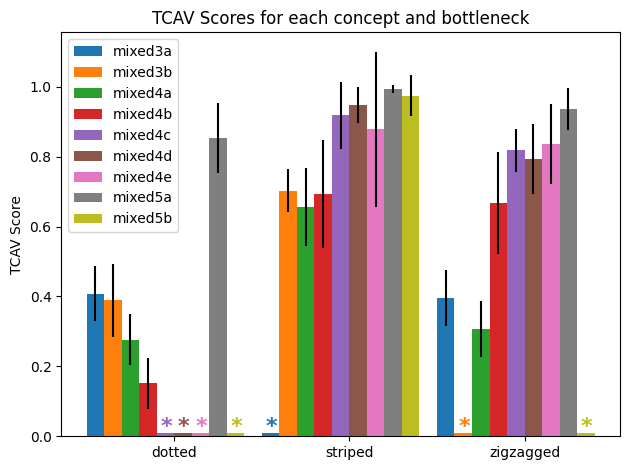

In [10]:
utils_plot.plot_results(results_zebra, num_random_exp=num_random_exp)

------------------

## 3. The Zebra Test Example

> This sections aims to test the methods with other zebra pictures than thoose provided by Imagenet. We have chosen the same amount of pictures, however this time the pictures are from CycleGAN Datasets [link](https://www.kaggle.com/datasets/balraj98/horse2zebra-dataset?resource=download-directory&select=trainB). 

>Step 1: Store concept and target class images to local folders

> **CHANGE THE NAME OF zebra_test folder to zebra, and the zebra folder to zebra_2. Moreover change project_name to new one.** Remeber to change back after running this section. 

In [4]:
# list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.
bottlenecks = [ 'mixed3a','mixed3b','mixed4a', 'mixed4b', 'mixed4c','mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']
# Possible layer names: 
# layer_names = ['conv2d0', 'conv2d1', 'conv2d2',
#                 'mixed3a', 'mixed3b',
#                 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
#                 'mixed5a', 'mixed5b']

# names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir
target = 'zebra'  
concepts = ["dotted","striped","zigzagged"]  

> Step 2: Write to the pretrained model wrapper

In [5]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = source_dir + "/pretrained_model/inception5h/tensorflow_inception_graph.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. 
LABEL_PATH = source_dir + "/pretrained_model/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

> Step 3: Implement a class that returns activations 

In [6]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir+'/concepts', activation_dir, max_examples=100)

> Step 4: Run TCAV and visualize concept importance

In [7]:
import absl
absl.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks, 
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:mixed3a ['dotted', 'random500_0'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_2'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_3'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_4'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_5'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_6'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_7'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_8'] zebra 0.1
INFO:tensorflow:mixed3a ['dotted', 'random500_9'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_0'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_2'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_3'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_4'] zebra 0.1
INFO:tensorflow:mixed3a ['striped', 'random500_5'] zebra 0.1
INFO:tensorflow:mixed3a ['striped'

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 170 of 1080
INFO:tensorflow:running zebra ['random500_2', 'random500_3']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_2_mixed3b shape (87, 28, 28, 480)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_3_mixed3b shape (73, 28, 28, 480)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_zebra_mixed3b shape (73, 28, 28, 480)
INFO:tensorflow:Training CAV ['random500_2', 'random500_3'] - mixed3b alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.32, 'random500_3': 0.5416666666666666, 'overall': 0.42857142857142855}
INFO:tensorflow:CAV accuracies: {'random500_2': 0.32, 'random500_3': 0.5416666666666666, 'overall': 0.42857142857142855}
INFO:tensorflow:Running param 171 of 1080
INFO:tensorflow:running zebra ['random500_2', 'random500_4']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_2_mixed3b shape (87, 28, 2

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 404 of 1080
INFO:tensorflow:running zebra ['random500_1', 'random500_6']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_1_mixed4b shape (82, 14, 14, 512)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_6_mixed4b shape (75, 14, 14, 512)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_zebra_mixed4b shape (73, 14, 14, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_6'] - mixed4b alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.2, 'random500_6': 0.88, 'overall': 0.54}
INFO:tensorflow:CAV accuracies: {'random500_1': 0.2, 'random500_6': 0.88, 'overall': 0.54}
INFO:tensorflow:Running param 405 of 1080
INFO:tensorflow:running zebra ['random500_1', 'random500_7']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_1_mixed4b shape (82, 14, 14, 512)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/a

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 789 of 1080
INFO:tensorflow:running zebra ['random500_4', 'random500_3']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_4_mixed4e shape (87, 14, 14, 832)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_3_mixed4e shape (73, 14, 14, 832)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_zebra_mixed4e shape (73, 14, 14, 832)
INFO:tensorflow:Training CAV ['random500_4', 'random500_3'] - mixed4e alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.7083333333333334, 'random500_3': 0.4, 'overall': 0.5510204081632653}
INFO:tensorflow:CAV accuracies: {'random500_4': 0.7083333333333334, 'random500_3': 0.4, 'overall': 0.5510204081632653}
INFO:tensorflow:Running param 790 of 1080
INFO:tensorflow:running zebra ['random500_4', 'random500_5']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_4_mixed4e shape (87, 14, 14, 8

c:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


INFO:tensorflow:Running param 802 of 1080
INFO:tensorflow:running zebra ['random500_5', 'random500_8']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_5_mixed4e shape (75, 14, 14, 832)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_8_mixed4e shape (74, 14, 14, 832)
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_zebra_mixed4e shape (73, 14, 14, 832)
INFO:tensorflow:Training CAV ['random500_5', 'random500_8'] - mixed4e alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.28, 'random500_8': 0.5833333333333334, 'overall': 0.42857142857142855}
INFO:tensorflow:CAV accuracies: {'random500_5': 0.28, 'random500_8': 0.5833333333333334, 'overall': 0.42857142857142855}
INFO:tensorflow:Running param 803 of 1080
INFO:tensorflow:running zebra ['random500_5', 'random500_9']
INFO:tensorflow:Loaded /tmp/andre/tcav_class_test4/activations/acts_random500_5_mixed4e shape (75, 14, 1

> Export the result to a json file in the 'result folder':

In [8]:
import json
with open('.\\results\\Zebra_all_layers_test', 'w+') as json_file:
    json.dump(results, json_file)

> Plot the results:

In [9]:
f = open('.\\results\\Zebra_all_layers_test', 'r')
results_zebra_test= json.load(f)


Class = zebra
  Concept = dotted
    Bottleneck = mixed3a. TCAV Score = 0.52 (+- 0.07), random was 0.50 (+- 0.11). p-val = 0.555 (not significant)
    Bottleneck = mixed3b. TCAV Score = 0.38 (+- 0.10), random was 0.51 (+- 0.12). p-val = 0.002 (significant)
    Bottleneck = mixed4a. TCAV Score = 0.27 (+- 0.10), random was 0.50 (+- 0.17). p-val = 0.000 (significant)
    Bottleneck = mixed4b. TCAV Score = 0.25 (+- 0.12), random was 0.49 (+- 0.16). p-val = 0.000 (significant)
    Bottleneck = mixed4c. TCAV Score = 0.44 (+- 0.14), random was 0.50 (+- 0.19). p-val = 0.328 (not significant)
    Bottleneck = mixed4d. TCAV Score = 0.76 (+- 0.16), random was 0.52 (+- 0.25). p-val = 0.004 (significant)
    Bottleneck = mixed4e. TCAV Score = 0.74 (+- 0.18), random was 0.48 (+- 0.25). p-val = 0.002 (significant)
    Bottleneck = mixed5a. TCAV Score = 0.88 (+- 0.11), random was 0.46 (+- 0.28). p-val = 0.000 (significant)
    Bottleneck = mixed5b. TCAV Score = 0.52 (+- 0.40), random was 0.51 (+- 0.32

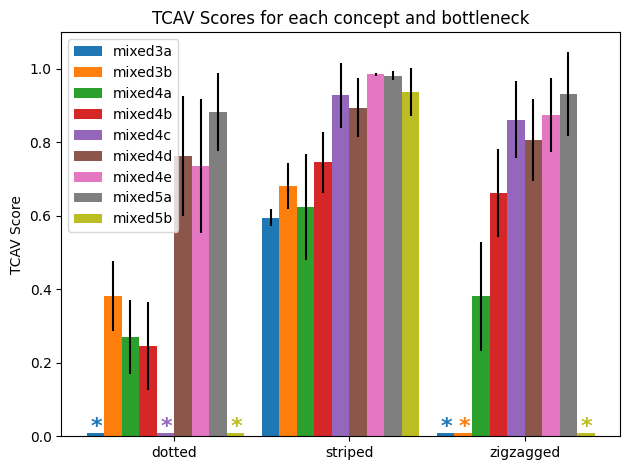

In [10]:
utils_plot.plot_results(results_zebra_test, num_random_exp=num_random_exp)

---------------------------

## 4. The School Bus Example 

>Step 1: Store concept and target class images to local folders

In [4]:
# list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.
bottlenecks = [ 'mixed3a','mixed3b','mixed4a', 'mixed4b', 'mixed4c','mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']
# Possible layer names: 
# layer_names = ['conv2d0', 'conv2d1', 'conv2d2',
#                 'mixed3a', 'mixed3b',
#                 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
#                 'mixed5a', 'mixed5b']

# names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir
target = 'school bus'  
concepts = ["man","woman","child"]  

> Step 2: Write to the pretrained model wrapper

In [5]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = source_dir + "/pretrained_model/inception5h/tensorflow_inception_graph.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. 
LABEL_PATH = source_dir + "/pretrained_model/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

> Step 3: Implement a class that returns activations 

In [6]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir+'/concepts', activation_dir, max_examples=100)

> Step 4: Run TCAV and visualize concept importance

In [7]:
import absl
absl.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:mixed3a ['man', 'random500_0'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_1'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_2'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_3'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_4'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_5'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_6'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_7'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_8'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_9'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_0'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_1'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_2'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_3'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_4'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_5'] school bus 

> Export the result to a json file in the 'result folder':

In [8]:
import json
with open('.\\results\\Schoolbus_all_layers', 'w+') as json_file:
    json.dump(results, json_file)

> Plot the results:

In [10]:
f = open('.\\results\\Schoolbus_all_layers', 'r')
results_schoolbus= json.load(f)


Class = school bus
  Concept = man
    Bottleneck = mixed3a. TCAV Score = 0.55 (+- 0.10), random was 0.50 (+- 0.19). p-val = 0.388 (not significant)
    Bottleneck = mixed3b. TCAV Score = 0.65 (+- 0.17), random was 0.51 (+- 0.21). p-val = 0.035 (significant)
    Bottleneck = mixed4a. TCAV Score = 0.74 (+- 0.12), random was 0.48 (+- 0.20). p-val = 0.000 (significant)
    Bottleneck = mixed4b. TCAV Score = 0.77 (+- 0.13), random was 0.50 (+- 0.26). p-val = 0.001 (significant)
    Bottleneck = mixed4c. TCAV Score = 0.66 (+- 0.25), random was 0.51 (+- 0.25). p-val = 0.077 (not significant)
    Bottleneck = mixed4d. TCAV Score = 0.69 (+- 0.18), random was 0.52 (+- 0.28). p-val = 0.059 (not significant)
    Bottleneck = mixed4e. TCAV Score = 0.91 (+- 0.08), random was 0.50 (+- 0.29). p-val = 0.000 (significant)
    Bottleneck = mixed5a. TCAV Score = 0.73 (+- 0.17), random was 0.52 (+- 0.31). p-val = 0.038 (significant)
    Bottleneck = mixed5b. TCAV Score = 0.66 (+- 0.32), random was 0.45 (+

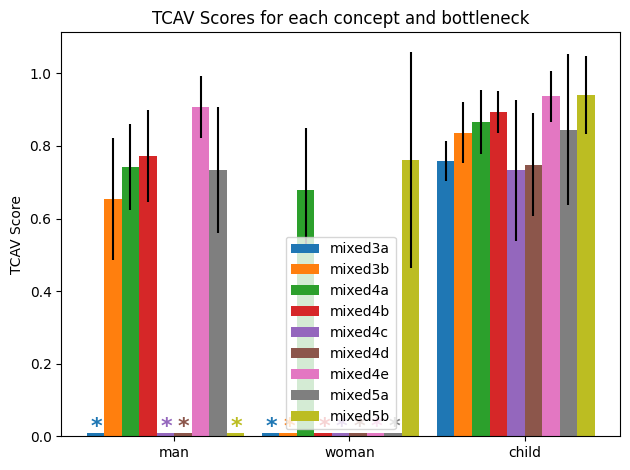

In [15]:
utils_plot.plot_results(results_schoolbus, num_random_exp=num_random_exp)

-----------------------

## 5. The School Bus Test Example 

> This sections aims to test the methods with other school bus pictures than thoose provided by Imagenet. We have chosen the same amount of pictures, however this time the pictures are from images.sv [link](https://images.cv/dataset/school-bus-image-classification-dataset). 

>Step 1: Store concept and target class images to local folders

> **CHANGE THE NAME OF schoolbus_test folder to school bus, and the school bus folder to school bus_2. Moreover change project_name to new one.** Remeber to change back after running this section. 

In [4]:
# list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.
bottlenecks = [ 'mixed3a','mixed3b','mixed4a', 'mixed4b', 'mixed4c','mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']
# Possible layer names: 
# layer_names = ['conv2d0', 'conv2d1', 'conv2d2',
#                 'mixed3a', 'mixed3b',
#                 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
#                 'mixed5a', 'mixed5b']

# names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir
target = 'school bus'  
concepts = ["man","woman","child"]

> Step 2: Write to the pretrained model wrapper

In [5]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = source_dir + "/pretrained_model/inception5h/tensorflow_inception_graph.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. 
LABEL_PATH = source_dir + "/pretrained_model/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

> Step 3: Implement a class that returns activations 

In [6]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir+'/concepts', activation_dir, max_examples=100)

> Step 4: Run TCAV and visualize concept importance

In [7]:
import absl 
absl.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:mixed3a ['man', 'random500_0'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_1'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_2'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_3'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_4'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_5'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_6'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_7'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_8'] school bus 0.1
INFO:tensorflow:mixed3a ['man', 'random500_9'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_0'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_1'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_2'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_3'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_4'] school bus 0.1
INFO:tensorflow:mixed3a ['woman', 'random500_5'] school bus 

> Export the result to a json file in the 'result folder':

In [8]:
import json
with open('.\\results\\Schoolbus_all_layers_test', 'w+') as json_file:
    json.dump(results, json_file)

> Plot the results:

In [9]:
f = open('.\\results\\Schoolbus_all_layers_test', 'r')
results_schoolbus_test= json.load(f)


Class = school bus
  Concept = man
    Bottleneck = mixed3a. TCAV Score = 0.49 (+- 0.15), random was 0.50 (+- 0.17). p-val = 0.829 (not significant)
    Bottleneck = mixed3b. TCAV Score = 0.68 (+- 0.11), random was 0.53 (+- 0.19). p-val = 0.016 (significant)
    Bottleneck = mixed4a. TCAV Score = 0.83 (+- 0.11), random was 0.51 (+- 0.20). p-val = 0.000 (significant)
    Bottleneck = mixed4b. TCAV Score = 0.74 (+- 0.18), random was 0.52 (+- 0.26). p-val = 0.014 (significant)
    Bottleneck = mixed4c. TCAV Score = 0.74 (+- 0.15), random was 0.51 (+- 0.28). p-val = 0.014 (significant)
    Bottleneck = mixed4d. TCAV Score = 0.72 (+- 0.24), random was 0.50 (+- 0.31). p-val = 0.041 (significant)
    Bottleneck = mixed4e. TCAV Score = 0.89 (+- 0.07), random was 0.49 (+- 0.30). p-val = 0.000 (significant)
    Bottleneck = mixed5a. TCAV Score = 0.72 (+- 0.22), random was 0.44 (+- 0.30). p-val = 0.005 (significant)
    Bottleneck = mixed5b. TCAV Score = 0.64 (+- 0.36), random was 0.47 (+- 0.39).

c:\Users\julie\Documents\GitHub\TCAV_Deep_Learning\tcav\utils_plot.py:96: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)


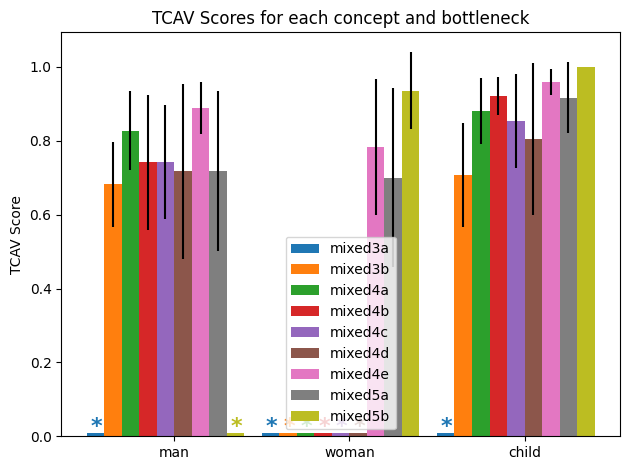

In [10]:
utils_plot.plot_results(results_schoolbus_test, num_random_exp=num_random_exp)

----------------------